# QBO in OpenIFS 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
import foci_functions

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39923 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:44309 Dashboard: http://127.0.0.1:39923/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
exp_list = ['FOCI_GJK029','FOCI_GJK029_r1i1p2']
time_list = [slice('2550-01-01','2600-01-01'), slice('1900-01-01','1950-01-01')]

In [6]:
ds_oifs_1m = foci_functions.read_openifs(exp_list, time_list, grid='regular_pl')

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/oifs/*1m*regular_pl.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029_r1i1p2/outdata/oifs/*1m*regular_pl.nc


In [7]:
# ERA Interim
machine = 'nesh'
if machine == 'sci':
    era_u = '/data/user/swahl/reanalysis_obs/era40-int/pressure_levels/u/u-eraint_monthly_0.75deg_1979-2016.nc'
elif machine == 'nesh':
    era_u = '/gxfs_work1/geomar/smomw352/reanalysis_obs/u-eraint-37plevels-monthly-1979-20190228.nc'
ds_pl_ei = xr.open_dataset(era_u, use_cftime=True).rename({'lev':'pressure_levels'})
u_pl_ei = ds_pl_ei['U']

## Upper-air zonal winds

In [8]:
def qbo(uwind):
    """
    Compute QBO from zonal wind 
    """
    
    # zonal mean wind profile at equator
    uprof = uwind.sel(lat=0,method='nearest').mean('lon')
    
    # remove seasonal cycle
    uprof_a = uprof.groupby('time.month') - uprof.groupby('time.month').mean('time')
    
    return uprof_a

In [9]:
#
# Compute zonal wind profiles for last 30 years
#

qbo_list = []

_qbo = qbo(u_pl_ei[-360:])
qbo_list.append(_qbo.compute())

for i, ds in enumerate(ds_oifs_1m):
    
    _qbo = qbo(ds['u'][-360:])
    qbo_list.append(_qbo.compute())


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


In [10]:
def psd(u):
    #u = ut.values
    freq = np.fft.rfftfreq(u.shape[0])
    df = 1. / u.shape[0]
    uhat = np.fft.rfft(u)
    uabs = np.abs(uhat) / u.shape[0]
    u_psd = uabs**2 / df 
    return freq,u_psd

In [37]:
def corr(da1, da2, dim='time'):
    """
    Compute Pearson correlation 
    """
    
    # Length of arrays
    n1 = len(da1[dim])
    n2 = len(da2[dim])
    
    if n1 != n2:
        print(' ERROR: Correlation of two arrays of different length does not work! ')
        print(' N1=%d, N2=%d ' % (n1,n2))
    else:
        n = n1
    
    # Anomalies
    da1_a = da1 - da1.mean(dim)
    da2_a = da2 - da2.mean(dim)
    
    # Covariance
    _cov = (da1_a * da2_a).sum(dim) / (n - 1)
    
    # Correlation
    _corr = _cov / (da1_a.std(dim) * da2_a.std(dim))
    
    return _corr
    

def autocorr(da_in, lags):
    
    ds_list = []
    
    for tau in lags:
        
        # Move data along time dimension
        da_shift = da_in.shift(time = tau)
        
        # Compute correlation
        _acorr = corr(da_in, da_shift)
        _acorr.name = da_in.name
        #_ds = _acorr.to_dataset()
        #_ds['tau'] = tau
        #ds_list.append(_ds)
        
        _acorr['tau'] = tau
        ds_list.append(_acorr)
        
        
    return xr.concat(ds_list, dim='tau')
        
acorr0 = autocorr(qbo_list[0], np.arange(-24,25,1))
acorr1 = autocorr(qbo_list[1], np.arange(-24,25,1))
acorr2 = autocorr(qbo_list[2], np.arange(-24,25,1))

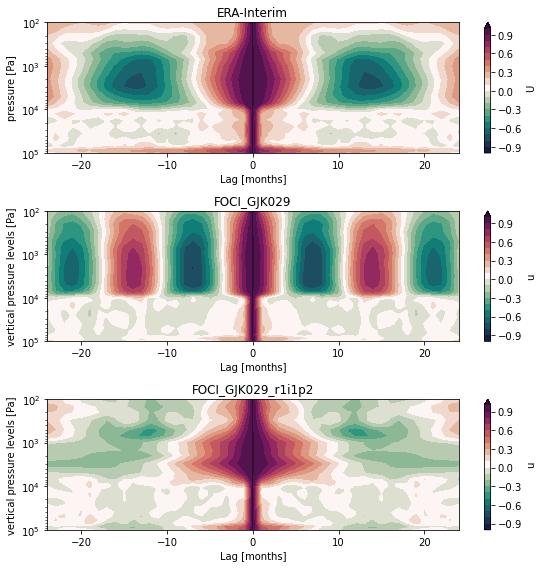

In [39]:
fig, axs = plt.subplots(3,1,figsize=(8,8))
ax = axs.flat

cf = acorr0.plot.contourf(ax=ax[0], x='tau', y='pressure_levels',
                          levels = np.linspace(-1,1,21),
                          cmap=cmocean.cm.curl)
# Rasterize to reduce plot size
# For contourf we need to rasterize each contour
for c in cf.collections:
    c.set_rasterized(True)
    
cf = acorr1.plot.contourf(ax=ax[1], x='tau', y='pressure_levels',
                          levels = np.linspace(-1,1,21),
                          cmap=cmocean.cm.curl)
for c in cf.collections:
    c.set_rasterized(True)
    
cf = acorr2.plot.contourf(ax=ax[2], x='tau', y='pressure_levels',
                          levels = np.linspace(-1,1,21),
                          cmap=cmocean.cm.curl)
for c in cf.collections:
    c.set_rasterized(True)
    
ax[0].set_title('ERA-Interim')
ax[1].set_title('FOCI_GJK029')
ax[2].set_title('FOCI_GJK029_r1i1p2')

for a in ax:
    a.set_yscale('log')
    a.set_ylim([100,100000])
    a.invert_yaxis()
    a.set_xlabel('Lag [months]')
    
fig.tight_layout()
fig.savefig('plots/qbo_picontrol_autocorrelation.pdf',format='pdf', dpi=150)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)


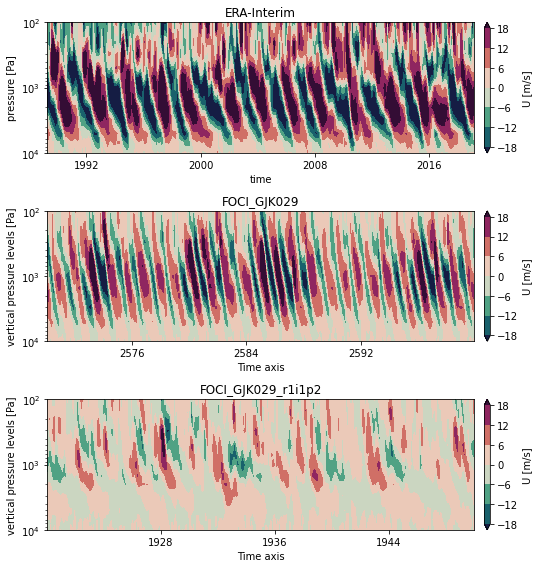

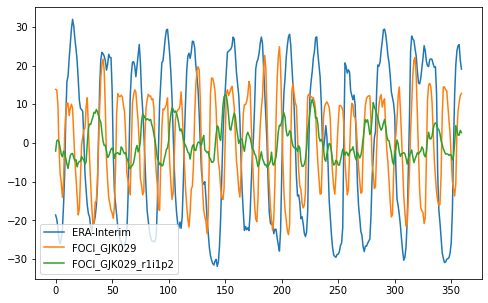

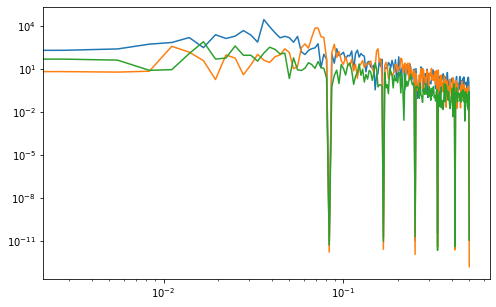

In [39]:
# Plot settings
umin1 = -18
umax1 = 18
ulevels1 = np.linspace(umin1,umax1,7)

cmap1 = cmocean.cm.curl

fig1,axs1 = plt.subplots(len(qbo_list),1,figsize=(8,8))
fig2, ax2 = plt.subplots(1,1, figsize=(8,5))
fig3, ax3 = plt.subplots(1,1, figsize=(8,5))

for j, _qbo in enumerate(qbo_list):
    i = j-1
    
    ckw = {'shrink':1, 'pad':0.02, 'extend':'both', 'label':'U [m/s]', 'orientation':'vertical'}
    _qbo.plot.contourf(x='time',y='pressure_levels',
                       ax=axs1[j],
                       levels=ulevels1,cmap=cmap1,
                       cbar_kwargs=ckw,
                       rasterized=True)
    
    if j == 0:
        exp = 'ERA-Interim'
    else:
        exp = exp_list[i]
    
    axs1[j].set_title('%s' % (exp,))
    
    _index = _qbo.sel(pressure_levels=2000,method='nearest').data
    ax2.plot(_index, label=exp)
    
    freq, u_psd = psd(_index)
    ax3.loglog(freq,u_psd,label='%s' % (exp,))
    
for ax in axs1:
    ax.set_yscale('log')
    ax.set_ylim([100,10000])
    ax.invert_yaxis()

ax2.legend()    

fig1.tight_layout()
fig1.savefig('plots/qbo_profile.pdf',format='pdf')

In [29]:


def ucomp(ut,up):
    u = ut.values
    
    # Identify wind flips from negative to positive 
    us = np.sign(u)
    uf = np.where( (us[0:-1]==-1) & (us[1:]==1) )[0]
    
    # Make composites of 5 step before and 45 steps after event
    uc = np.zeros((50))
    xc = np.arange(-5,45)
    n = 0
    for f in uf:
        if (f > 5) and (f < u.shape[0]-45):
            uc = uc + u[f-5:f+45]
            n = n + 1
    uc = uc / n

<xarray.DataArray 'u' (time: 360)>
dask.array<mean_agg-aggregate, shape=(360,), dtype=float32, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
    lat              float32 0.9375
    pressure_levels  float32 2e+03
    time_centered    (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time             (time) object 2430-01-16 12:00:00 ... 2459-12-16 12:00:00
<xarray.DataArray 'u' (time: 360)>
dask.array<getitem, shape=(360,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat              float32 0.9375
    pressure_levels  float32 2e+03
    time_centered    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time             (time) object 2430-01-16 12:00:00 ... 2459-12-16 12:00:00
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


[  0  15  29  42  55  68  81  94 109 123 137 150 164 178 193 207 219 232
 246 260 273 285 298 311 326 339 354]
0
15
29
42
55
68
81
94
109
123
137
150
164
178
193
207
219
232
246
260
273
285
298
311
326
339
354


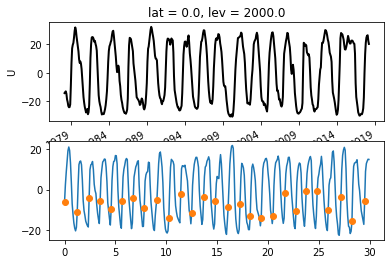

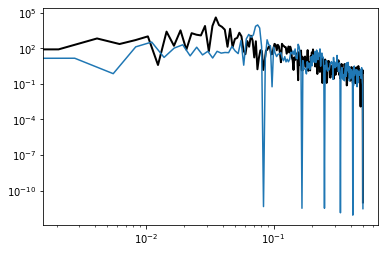

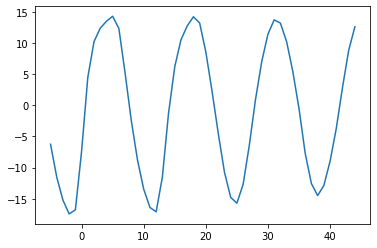

In [42]:
# Select 20 hPa for time series analysis
fig1, ax1 = plt.subplots(2,1)
fig2, ax2 = plt.subplots(1,1)
fig3, ax3 = plt.subplots(1,1)

# Zonal mean zonal equatorial wind
u_zt = u_pl_ei.sel(lat=0,method='nearest').sel(lev=2000).mean('lon')
# Remove seasonal cycle
u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')

u_zt_a.plot(ax=ax1[0],label='ERA-I',color='k',linewidth=2)

# Spectral analysis
freq, u_psd = psd(u_zt_a)
ax2.loglog(freq,u_psd,label='ERA-I',color='k',linewidth=2)

for j in range(0,len(ds_pl_all)):
    exp = exp_list[j]
    ds_pl = ds_pl_all[j]
    
    # Zonal mean zonal equatorial wind
    u_zt = ds_pl['u'][-360:].sel(lat=0,method='nearest').sel(pressure_levels=2000).mean('lon')
    print(u_zt)
    
    # Remove seasonal cycle
    u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')
    print(u_zt_a)
    
    #u_zt_a.plot(ax=ax1,label='%s' % (exp,))
    x = np.arange(0,u_zt_a.values.shape[0],1) / 12
    ax1[j+1].plot(x,u_zt_a.values)
    
    ax1[j+1].plot(x[uf],u[uf],'o')
    
    freq, u_psd = psd(u_zt_a)
    ax2.loglog(freq,u_psd,label='%s' % (exp,))
    
    ax3.plot(xc,uc)

#fig1.tight_layout()
#fig1.savefig('qbo_%s_erai.png' % (exp,),format='png')

<xarray.DataArray 'u' (time: 360)>
dask.array<mean_agg-aggregate, shape=(360,), dtype=float32, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
    lat              float32 0.9375
    pressure_levels  float32 2e+03
    time_centered    (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time             (time) object 2430-01-16 12:00:00 ... 2459-12-16 12:00:00

## Surface pressure and zonal wind

## Winds

## Temperature biases